In [500]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#Loading the dataset
test_data = pd.read_csv('TargetData.csv')


#Print the first 5 rows of the dataframe.
test_data.head()

X = test_data.drop(["ID","SB","COL","Margin","Block","ROW"],axis = 1)
y = test_data.SB

In [501]:
#post pruning
from sklearn.tree._tree import TREE_LEAF

def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and 
            inner_tree.children_right[index] == TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        ##print("Pruned {}".format(index))

def prune_duplicate_leaves(mdl):
    # Remove leaves if both 
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)

In [502]:
#importing train_test_split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=2, stratify=y)

from sklearn.tree import DecisionTreeClassifier

max_accuracy=0
best_depth=12
best_impurity_decrease=0.0001
best_weight_fraction_leaf=0.001
for DEPTH in range(12,21,1):
    dt = DecisionTreeClassifier(criterion='entropy',max_depth=DEPTH,random_state=0,min_impurity_decrease=0.0001,min_weight_fraction_leaf=0.001)
    dt.fit(X_train, y_train)
    #post_pruning
    prune_duplicate_leaves(dt)

    print(DEPTH,dt.score(X_test, y_test))
    if dt.score(X_test, y_test)>max_accuracy: 
        max_accuracy=dt.score(X_test, y_test)
        best_depth=DEPTH
        
for impurity_decrease in range(5,15,1):

    dt = DecisionTreeClassifier(criterion='entropy',max_depth=best_depth,random_state=0,min_impurity_decrease=impurity_decrease*0.00001,min_weight_fraction_leaf=0.001)
    dt.fit(X_train, y_train)
    #post_pruning
    prune_duplicate_leaves(dt)

    print(best_depth,impurity_decrease,dt.score(X_test, y_test))
    if dt.score(X_test, y_test)>max_accuracy: 
        max_accuracy=dt.score(X_test, y_test)
        best_impurity_decrease=impurity_decrease*0.00001
        
for weight_fraction_leaf in range(5,15,1):
    dt = DecisionTreeClassifier(criterion='entropy',max_depth=best_depth,random_state=0,min_impurity_decrease=best_impurity_decrease,min_weight_fraction_leaf=weight_fraction_leaf*0.0001)
    dt.fit(X_train, y_train)
    #post_pruning
    prune_duplicate_leaves(dt)

    print(best_depth,best_impurity_decrease,weight_fraction_leaf,dt.score(X_test, y_test))
    if dt.score(X_test, y_test)>max_accuracy: 
        max_accuracy=dt.score(X_test, y_test)
        best_weight_fraction_leaf=weight_fraction_leaf*0.0001

        
    

dt = DecisionTreeClassifier(criterion='entropy',max_depth=best_depth,random_state=0,min_impurity_decrease=best_impurity_decrease,min_weight_fraction_leaf=best_weight_fraction_leaf)
dt.fit(X_train, y_train)    

#post_pruning
prune_duplicate_leaves(dt)

print("selected depth: {:d}".format(best_depth))
print("selected best_impurity_decrease: {:.8f}".format(best_impurity_decrease))
print("selected best_weight_fraction_leaf: {:.8f}".format(best_weight_fraction_leaf))
print("Accuracy on training set: {:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(dt.score(X_test, y_test)))

12 0.8496605237633366
13 0.8506304558680893
14 0.8506304558680893
15 0.8496605237633366
16 0.8496605237633366
17 0.8506304558680893
18 0.8496605237633366
19 0.8506304558680893
20 0.8506304558680893
13 5 0.8496605237633366
13 6 0.8496605237633366
13 7 0.8496605237633366
13 8 0.8496605237633366
13 9 0.8506304558680893
13 10 0.8506304558680893
13 11 0.8506304558680893
13 12 0.8506304558680893
13 13 0.8496605237633366
13 14 0.8496605237633366
13 0.0001 5 0.8506304558680893
13 0.0001 6 0.8506304558680893
13 0.0001 7 0.8506304558680893
13 0.0001 8 0.8496605237633366
13 0.0001 9 0.8496605237633366
13 0.0001 10 0.8506304558680893
13 0.0001 11 0.8506304558680893
13 0.0001 12 0.8506304558680893
13 0.0001 13 0.8496605237633366
13 0.0001 14 0.8496605237633366
selected depth: 13
selected best_impurity_decrease: 0.00010000
selected best_weight_fraction_leaf: 0.00100000
Accuracy on training set: 0.865
Accuracy on test set: 0.851


In [503]:
y_pred = dt.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  

print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 

[[464  64]
 [ 90 413]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       528
           1       0.87      0.82      0.84       503

    accuracy                           0.85      1031
   macro avg       0.85      0.85      0.85      1031
weighted avg       0.85      0.85      0.85      1031



In [504]:
#DT visualizatin method 1

from sklearn.tree import export_graphviz

dotfile = open("dt2.dot", 'w')

export_graphviz(dt, out_file=dotfile,feature_names = X.columns,class_names=['0','1'])
dotfile.close()
# Copying the contents of the created file ('dt2.dot' ) to a graphviz rendering agent at http://webgraphviz.com/
# check out https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html



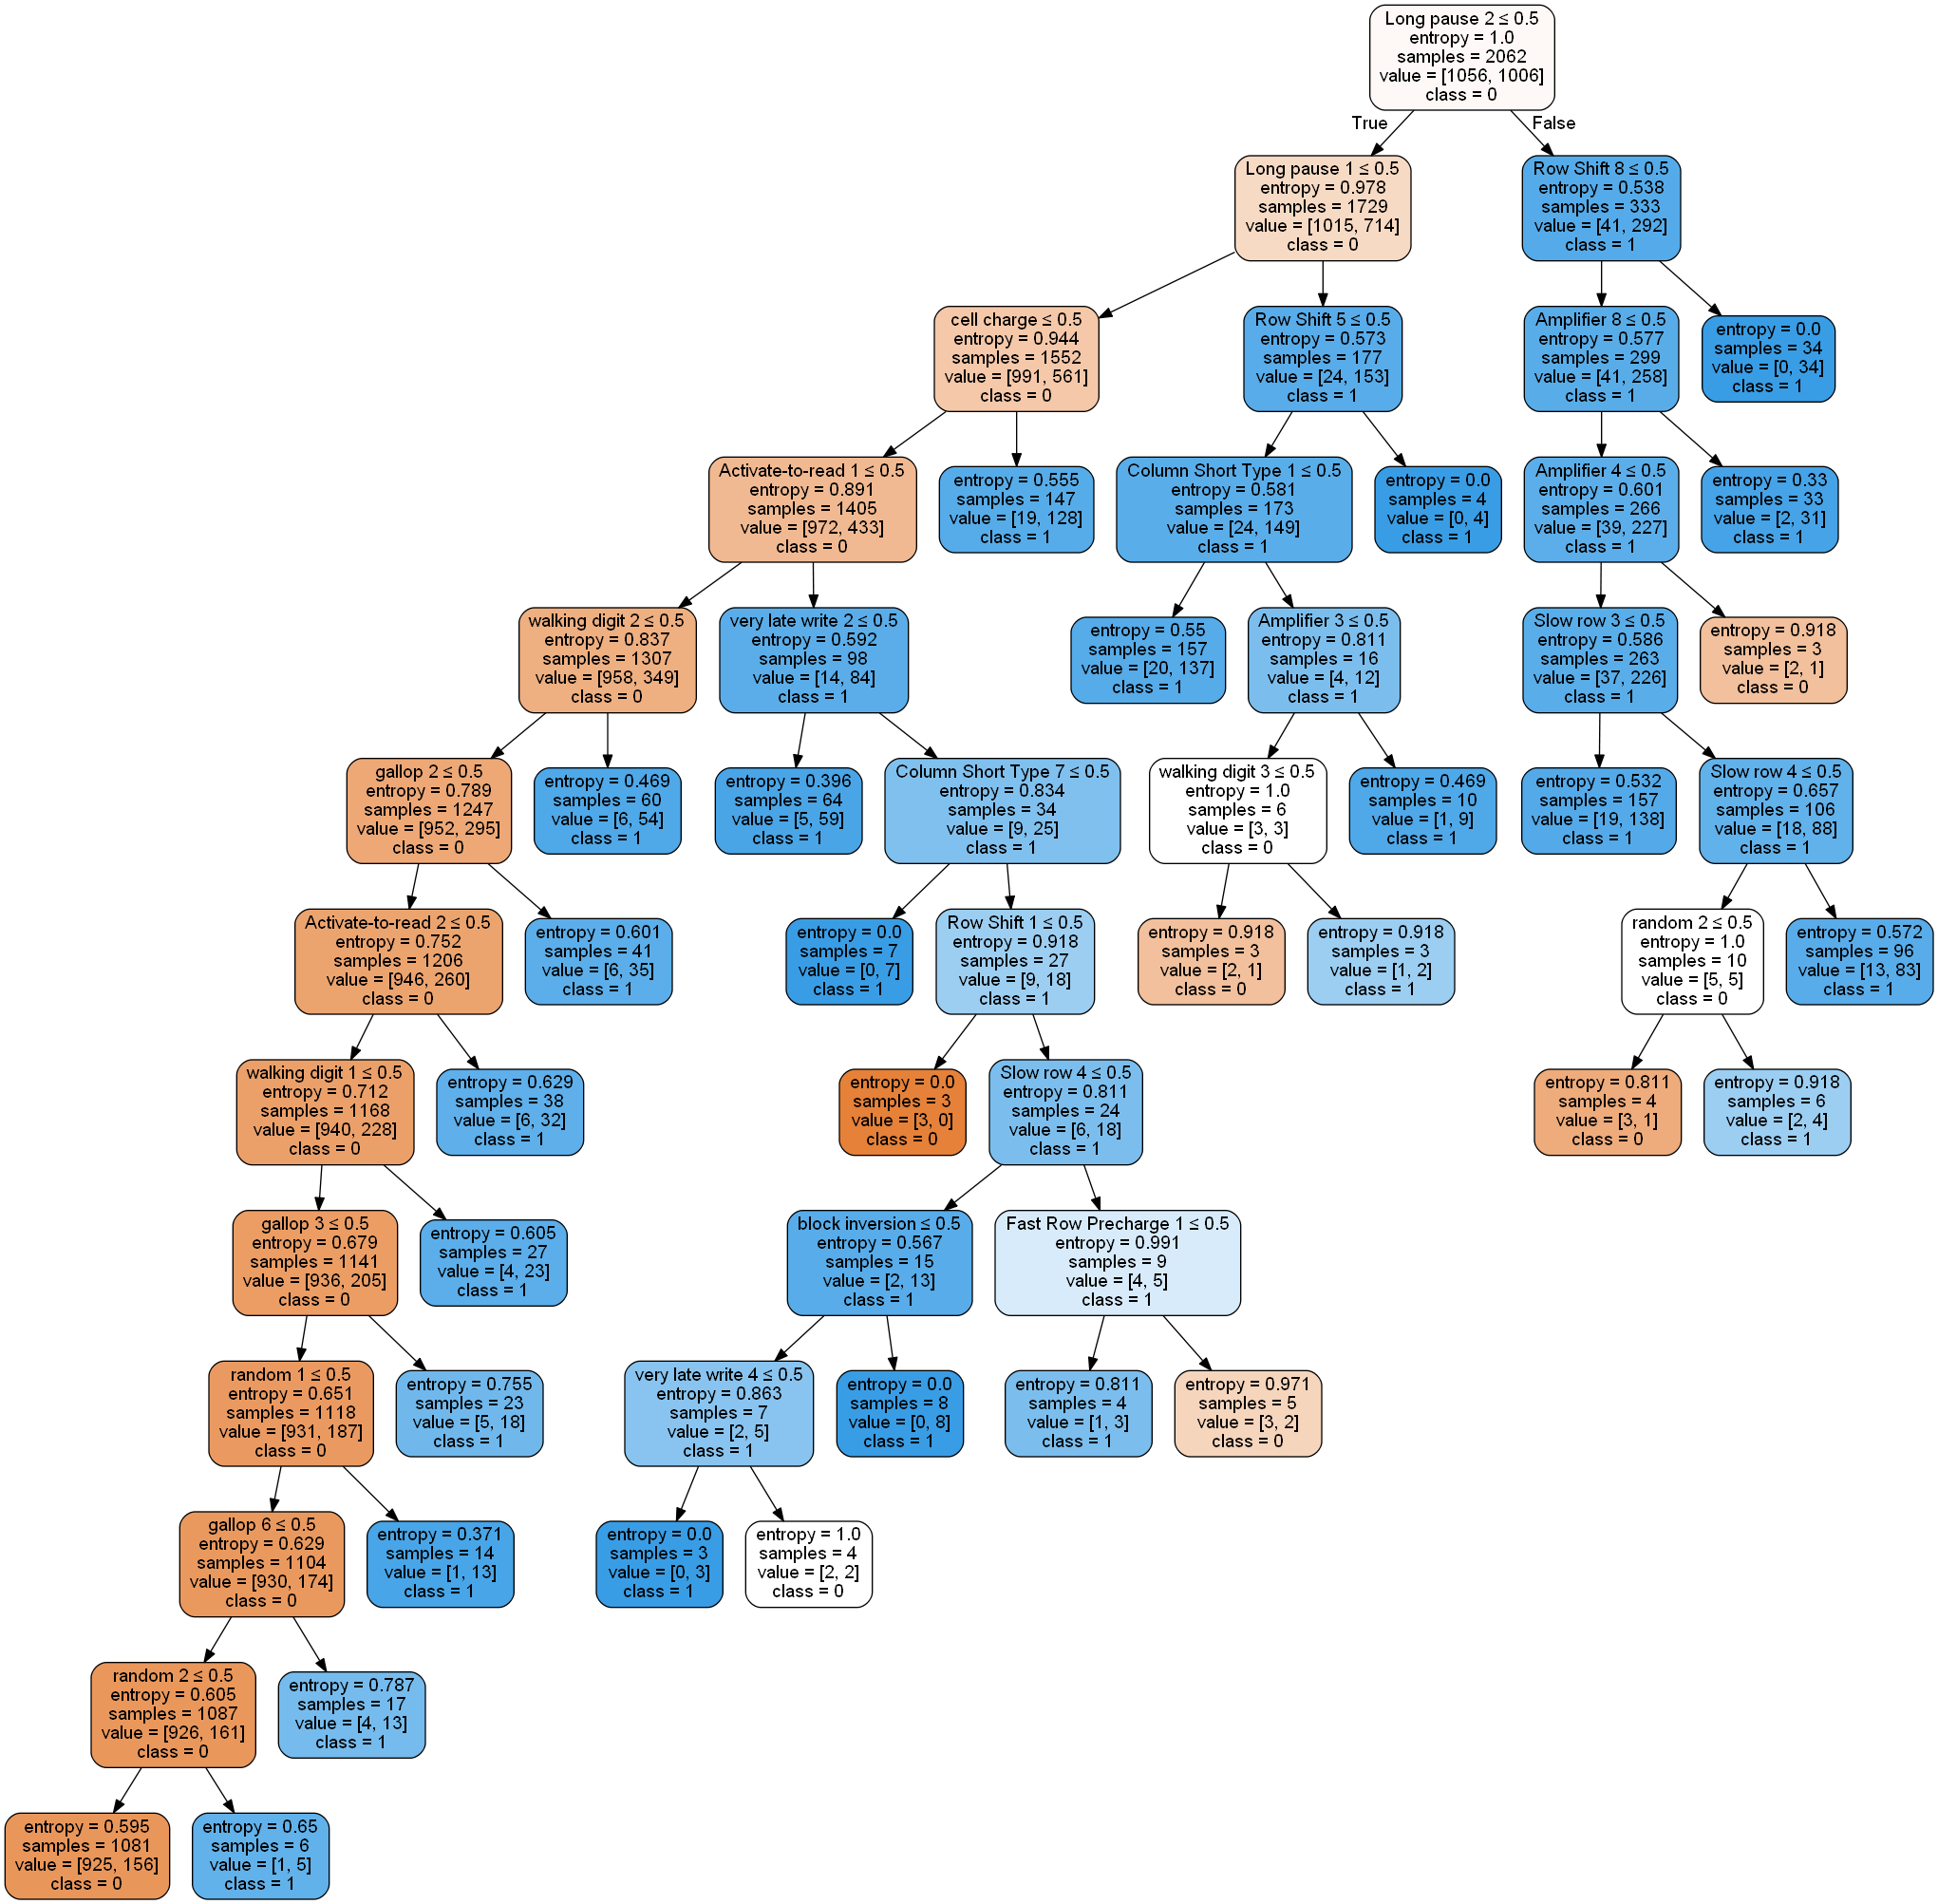

In [505]:
#DT visualizatin method 3
#!conda install -y pydotplus
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('testClassified.png')
Image(graph.create_png())

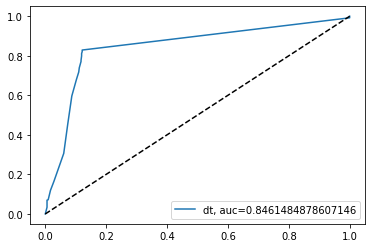

In [506]:
from sklearn import metrics

y_pred_proba = dt.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="dt, auc="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.show()

In [507]:
print(dt.feature_importances_)
#print(sorted(dt.feature_importances_))

ranked_feature=[]
for i in range(58):
    ranked_feature.append('')
sorted_importance=sorted(dt.feature_importances_)
for i in range( len(dt.feature_importances_) ):
    if dt.feature_importances_[i]>0.20*sorted_importance[-1] or sorted_importance.index(dt.feature_importances_[i]) > len(dt.feature_importances_)-best_depth-1:
        #print(i)
        ranked_feature[57-sorted_importance.index(dt.feature_importances_[i])]=test_data.columns[i+1]
        
for f in ranked_feature:
    if f != "":
        print(f)
    

[0.1446296  0.         0.         0.0009028  0.00586214 0.00124275
 0.         0.         0.         0.13736015 0.10989716 0.04450498
 0.09006967 0.         0.         0.         0.21019365 0.
 0.05799668 0.         0.         0.00097577 0.00270438 0.00053985
 0.03247656 0.         0.         0.03209586 0.00749037 0.
 0.         0.00475893 0.         0.         0.02511062 0.
 0.01260059 0.05632418 0.00252234 0.         0.00337808 0.
 0.         0.         0.00093744 0.00391376 0.         0.
 0.         0.00224852 0.00174806 0.         0.         0.
 0.         0.         0.         0.00751513]
Long pause 2
cell charge
Long pause 1
Activate-to-read 1
walking digit 2
gallop 2
Activate-to-read 2
walking digit 1
gallop 3
random 1
gallop 6
random 2
Row Shift 8


In [508]:
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000,verbose=2)  
mlp.fit(X_train, y_train)  

predictions = mlp.predict(X_test)  


print("Accuracy", metrics.accuracy_score(y_test, predictions))
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))  
print(mlp.coefs_[0][1])

Iteration 1, loss = 0.79182163
Iteration 2, loss = 0.74936504
Iteration 3, loss = 0.71572269
Iteration 4, loss = 0.68403877
Iteration 5, loss = 0.65525360
Iteration 6, loss = 0.62853074
Iteration 7, loss = 0.60794303
Iteration 8, loss = 0.59242331
Iteration 9, loss = 0.57997793
Iteration 10, loss = 0.56895420
Iteration 11, loss = 0.55849667
Iteration 12, loss = 0.54821253
Iteration 13, loss = 0.53757055
Iteration 14, loss = 0.52817231
Iteration 15, loss = 0.51930307
Iteration 16, loss = 0.51054871
Iteration 17, loss = 0.50255784
Iteration 18, loss = 0.49499712
Iteration 19, loss = 0.48835163
Iteration 20, loss = 0.48120776
Iteration 21, loss = 0.47484647
Iteration 22, loss = 0.46923730
Iteration 23, loss = 0.46350926
Iteration 24, loss = 0.45878484
Iteration 25, loss = 0.45404522
Iteration 26, loss = 0.44978157
Iteration 27, loss = 0.44579313
Iteration 28, loss = 0.44235207
Iteration 29, loss = 0.43843347
Iteration 30, loss = 0.43559854
Iteration 31, loss = 0.43255053
Iteration 32, los

Iteration 281, loss = 0.36490510
Iteration 282, loss = 0.36517335
Iteration 283, loss = 0.36573853
Iteration 284, loss = 0.36509510
Iteration 285, loss = 0.36577907
Iteration 286, loss = 0.36463071
Iteration 287, loss = 0.36487711
Iteration 288, loss = 0.36502367
Iteration 289, loss = 0.36476842
Iteration 290, loss = 0.36447537
Iteration 291, loss = 0.36479838
Iteration 292, loss = 0.36435292
Iteration 293, loss = 0.36431295
Iteration 294, loss = 0.36471631
Iteration 295, loss = 0.36411430
Iteration 296, loss = 0.36431381
Iteration 297, loss = 0.36497789
Iteration 298, loss = 0.36454730
Iteration 299, loss = 0.36394183
Iteration 300, loss = 0.36430625
Iteration 301, loss = 0.36424842
Iteration 302, loss = 0.36432097
Iteration 303, loss = 0.36398995
Iteration 304, loss = 0.36374582
Iteration 305, loss = 0.36371553
Iteration 306, loss = 0.36370042
Iteration 307, loss = 0.36343350
Iteration 308, loss = 0.36342530
Iteration 309, loss = 0.36316342
Iteration 310, loss = 0.36361631
Iteration 

In [509]:


feature={}
node_feature=[]

for l in range(10):
    min_weight=mlp.coefs_[0][0:][l].min()
    max_weight=mlp.coefs_[0][0:][l].max()
    if abs(min_weight)>abs(max_weight): max_weight=abs(min_weight)
    max_weight=abs(max_weight)
    for i in range(58):
        weight = mlp.coefs_[0][i][l]
        if weight>0 and weight/max_weight>0.33: 
            if test_data.columns[i+1] not in feature: 
                feature[ test_data.columns[i+1] ]=0
            feature[ test_data.columns[i+1] ]+=1
            node_feature.append(test_data.columns[i+1])
        #elif weight<0 and weight/max_weight>0.33: 
            #if test_data.columns[i+1] not in feature: 
            #    feature[ test_data.columns[i+1] ]=0
            #feature[ test_data.columns[i+1] ]+=1
            #node_feature.append(test_data.columns[i+1])
    #print(node_feature)
    #node_feature=[]
        
#for f in feature: 
#    if feature[f]>5: print(f)
        
    
    

In [510]:
featurelist=[]
feature_freq=[]
notfeature_freq=[]
for testnum in range(58):
    featurelist.append( test_data.columns[testnum+1] )
    feature_freq.append(0)
    notfeature_freq.append(0)

for i in range(len(X_test)):
    if predictions[i]==1:
        total_ones=0
        total_zeros=0
        for testnum in range(58):
            if X_test[i][testnum]>=0.45: #if transformed X is greater than 0.5
                total_ones+=1
            else:
                total_zeros+=1
        
        for testnum in range(58):
            if X_test[i][testnum]>=0.45: #if transformed X is greater than 0.5
                feature_freq[testnum]+=1/total_ones
            else:
                notfeature_freq[testnum]+=1/total_zeros
                
#print (X_test[0])
sorted_featurelist=[]
sorted_notfeaturelist=[]
for i in range(58):
    sorted_featurelist.append([])
    sorted_notfeaturelist.append([])
sorted_freq=sorted( feature_freq )                
for i in range(len(feature_freq)):
    if feature_freq[i]>0.25*sorted_freq[-1] or sorted_freq.index( feature_freq[i] )>0.75*58:
        if feature_freq[i]>1.5*notfeature_freq[i]:
            sorted_featurelist[57-sorted_freq.index( feature_freq[i] )]=[featurelist[i],feature_freq[i],notfeature_freq[i]]
        
#positive,negative prediction frequency for selected features with significant importance
for f in sorted_featurelist:
    if f!=[]:
        print(f)    
        

['Long pause 2', 88.94729921175553, 6.179427545622026]
['Long pause 1', 83.93634733360776, 6.734477914146731]
['cell charge', 70.94658455399615, 6.301044744794637]
['gallop 2', 18.270752001466963, 6.241844332285745]
['walking digit 1', 17.53131344332217, 6.425189488949231]
['gallop 3', 16.8977361284511, 6.281542158416564]
['walking digit 2', 15.953650365659096, 6.6290838939544585]
['Activate-to-read 2', 14.769109219932881, 6.379424633583594]
['Activate-to-read 1', 13.840220331044003, 6.537551894124316]
